# Multi-class Dog Breed Classification
Multi-class image classification using Tensorflow 2.0 and Tensorflow Hub

## Data
https://www.kaggle.com/competitions/dog-breed-identification/overview

### TODO:
- Manipulate (crop, resize) or distort them (flip, rotate) to augment and enhance the training dataset. https://www.tensorflow.org/api_docs/python/tf/image
- "How to improve a TensorFlow 2.x image classification model?"
- "TensorFlow 2.x image classification best practices"
- "Transfer learning for image classification with TensorFlow 2.x"
- "Deep learning project examples with TensorFlow 2.x"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from pathlib import Path
from datetime import date, datetime, timedelta, timezone
import numpy, pandas as pd, seaborn, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, MaxPooling2D, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetV2L
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
labels_csv = pd.read_csv("data/dog-breed-identification/labels.csv") # the breeds for the images in the train set
print(labels_csv.describe())
print(labels_csv.head());

2025-09-29 18:51:26.385097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 18:51:26.429147: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 18:51:27.525042: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


/home/khteh/.local/share/virtualenvs/JupyterNotebooks-uVG1pv5y/lib/python3.13/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


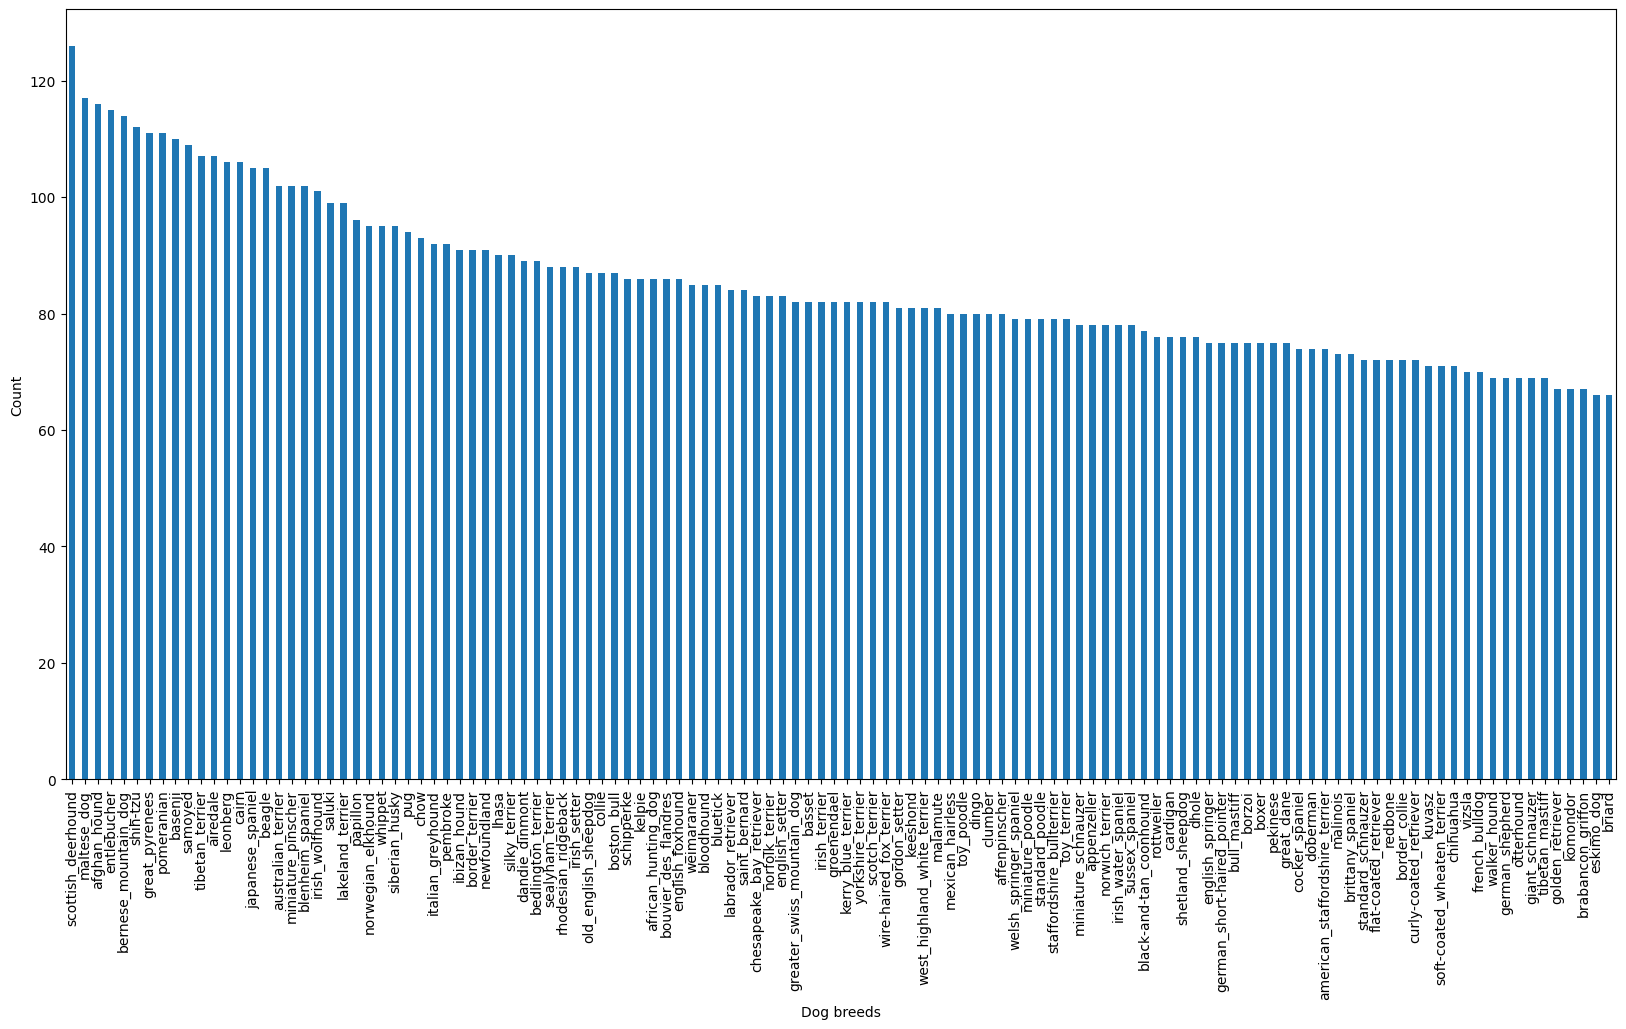

In [2]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10)) # figsize = (width, height)
plt.xlabel("Dog breeds");
plt.ylabel("Count");

In [3]:
train_filenames = [f"data/dog-breed-identification/train/{f}.jpg" for f in labels_csv["id"]]
labels = labels_csv["breed"].to_numpy()
assert len(labels) == len(train_filenames)
assert len(os.listdir("data/dog-breed-identification/train/")) == len(train_filenames)
print(f"train dataset size: {len(labels)}")
train_filenames[:10]
unique_breeds = numpy.unique(labels)
print(f"{len(unique_breeds)} unique breeds")
unique_breeds

train dataset size: 10222
120 unique breeds


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

## Label Encoding
- Turn every label into one-hot encoded boolean array
- This effectively encodes the string labels. The prediction probabilities will follow the order of this encoded array for the probability to label mapping.

In [4]:
bool_labels = [l == unique_breeds for l in labels] # Y
assert len(unique_breeds) == len(bool_labels[0])
bool_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [5]:
# Example: Turn bool array into integer array
print(labels[0]) # original label
index = numpy.where(unique_breeds == labels[0])
print(f"Index of {labels[0]} is {index}: {unique_breeds[index[0][0]]}") # Index of the breed
print(f"{labels[0]} is True at {bool_labels[0].argmax()}")

boston_bull
Index of boston_bull is (array([19]),): boston_bull
boston_bull is True at 19


In [6]:
# Train, validation and test datasets
X = train_filenames
Y = bool_labels
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
# Split the training dataset into training and validation of NUM_IMAGES total size
#X_train, X_validation, Y_train, Y_validation = train_test_split(X[:NUM_IMAGES], Y[:NUM_IMAGES], test_size=0.2)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2)
print(f"X_train: {len(X_train)}, Y_train: {len(Y_train)}, X_validation: {len(X_validation)}, Y_validation: {len(Y_validation)}")
# Check out the training data (image file paths and labels)
#X_train[:5], Y_train[:2]
Y_train[:2]
#X_train_tensors = tf.constant(X_train)
#Y_train_tensors = tf.constant(Y_train)
#print(f"X_train_tensors: {X_train_tensors.shape}, Y_train_tensors: {Y_train_tensors.shape}")

X_train: 8177, Y_train: 8177, X_validation: 2045, Y_validation: 2045


[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [7]:
image = imread(train_filenames[42]) # read in an image
image.shape # (M, N, 4) (height, width, RGB+Apha)

(257, 350, 3)

In [69]:
# Process images into tensors
# Use the same image shape as this transfer model https://www.kaggle.com/models/google/mobilenet-v2/tensorFlow2/140-224-classification
IMAGE_SIZE=224 # Try to use a square image.
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(f"IMG_SHAPE: {IMG_SHAPE}")
BATCH_SIZE=32

def ProcessImage(path: str, size=IMAGE_SIZE) -> tf.Tensor:
    """
    Process input image file content into a tensor.
    """
    img: tf.Tensor = tf.io.read_file(path)
    #print(f"img type: {type(img)}")
    # Turn the JPG image into numerical tensor with 3 colour channels (RGB)
    # https://www.tensorflow.org/api_docs/python/tf/io/decode_jpeg
    img = tf.image.decode_jpeg(img, channels=3)
    # Normalize the colour channel values from 0-255 to 0-1
    img = tf.image.convert_image_dtype(img, tf.float32) # https://www.tensorflow.org/api_docs/python/tf/image/convert_image_dtype
    # Resize the image
    img = tf.image.resize(img, size=[size, size])
    return img

def get_image_label(path: str, label, size=IMAGE_SIZE):
    """
    Convenience function to pack 2 input parameters into a tuple.
    Return: (Image, label)
    """
    return ProcessImage(path, size), label

IMG_SHAPE: (224, 224, 3)


In [61]:
# Turn data into batches to fit into memory. Recommended batch size is 32.
# Data in the form of tensor tuple (image, label)
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE, isValidation=False, isTest=False):
    """
    Creates batches of data out of image (X) and label (Y) pairs.
    Shuffle only if the input is training dataset.
    Accepts test dataset as input without labels.

    Input:
    X: list of file paths
    Y: One-hot encoded boolean labels
    """
    if isTest:
        print("Create test data batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # list
        return data.map(ProcessImage).batch(batch_size)
    elif isValidation:
        print("Create validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y))) # tuples of (path, label)
        return data.map(get_image_label).batch(batch_size)
    else:
        print("Create training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(Y)))  # tuples of (path, label)
        # Suffling simple data types especially with fewer dimensions is faster than shuffling the images with 3 dimension.
        return data.shuffle(len(X)).map(get_image_label).batch(batch_size)

In [62]:
train_data = create_data_batches(X_train, Y_train, BATCH_SIZE)
validation_data = create_data_batches(X_validation, Y_validation, BATCH_SIZE, isValidation=True)
# ((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
#  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
# (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
#  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))
train_data.element_spec, validation_data.element_spec

Create training data batches...
ProcessImage(): min: Tensor("Min:0", shape=(), dtype=float32), max: Tensor("Max:0", shape=(), dtype=float32)
Create validation data batches...
ProcessImage(): min: Tensor("Min:0", shape=(), dtype=float32), max: Tensor("Max:0", shape=(), dtype=float32)


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [63]:
# Visualize data batches
def ShowDataBatch(images, labels):
    """
    Plot 25 images and their labels in the batch.
    """
    plt.figure(figsize=(10,10))
    for i in range(25):
        # Create 5x5 subplots
        ax = plt.subplot(5,5,i+1) # index starts at 1 in the upper-left corner
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

(np.float32(0.440386), np.float32(0.0), np.float32(1.0))

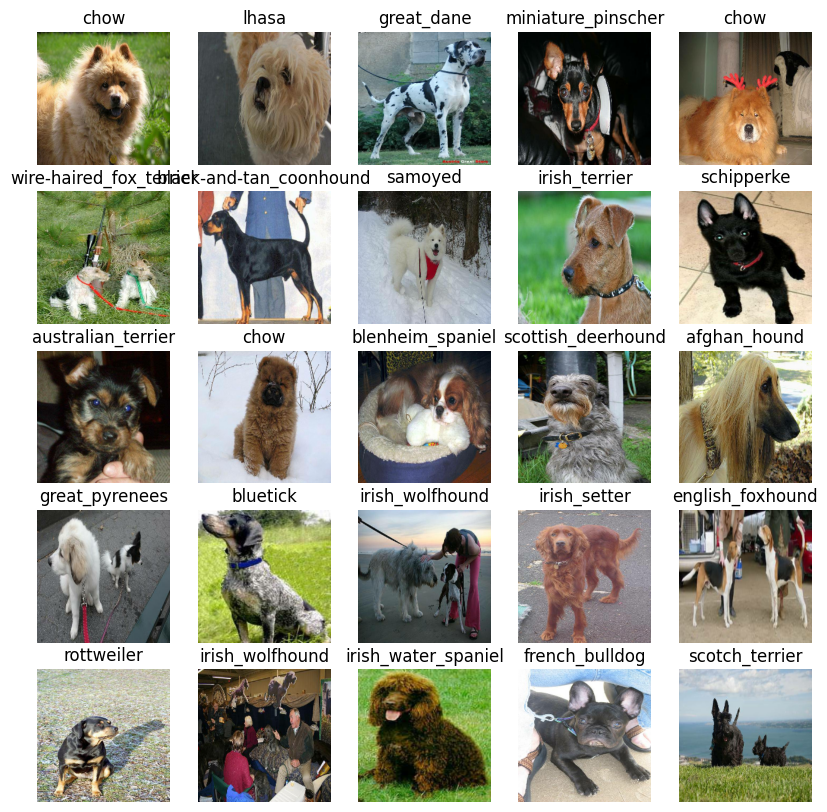

In [64]:
train_images, train_labels = next(train_data.as_numpy_iterator())
assert BATCH_SIZE == len(train_images)
assert BATCH_SIZE == len(train_labels)
ShowDataBatch(train_images, train_labels)
numpy.mean(train_images[0]), numpy.min(train_images[0]), numpy.max(train_images[0])

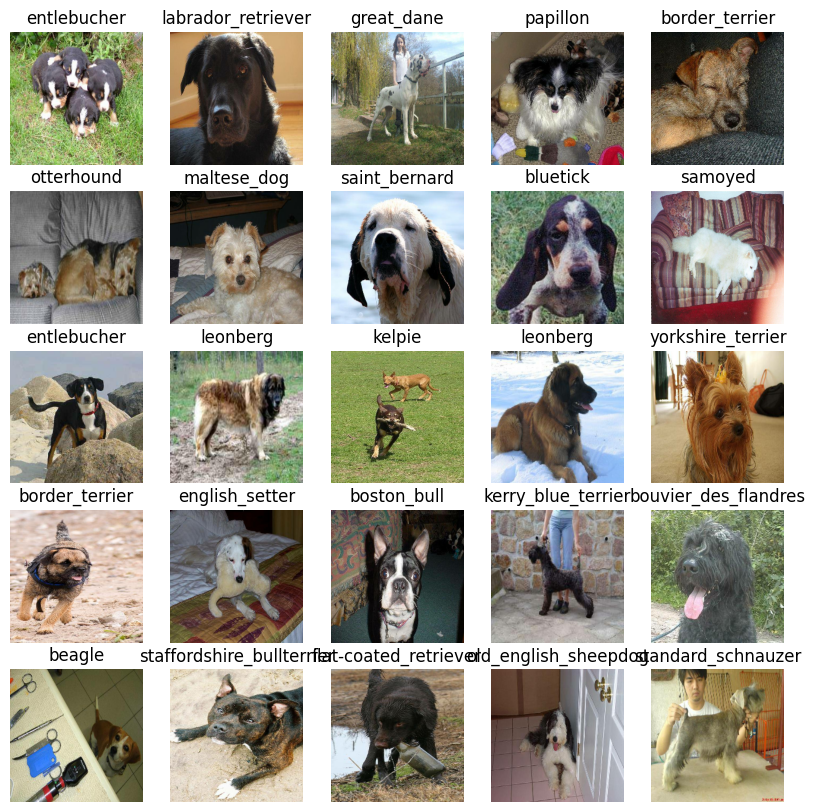

In [65]:
validation_images, validation_labels = next(validation_data.as_numpy_iterator())
assert BATCH_SIZE == len(validation_images)
assert BATCH_SIZE == len(validation_labels)
ShowDataBatch(validation_images, validation_labels)

In [66]:
# UNQ_C1
# GRADED FUNCTION: data_augmenter
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    datagen = ImageDataGenerator(
        rotation_range=40, #
        width_shift_range=0.2, #
        height_shift_range=0.2, #
        shear_range=0.2, # deprecated
        zoom_range=0.2, #
        horizontal_flip=True, #
        fill_mode='nearest' #)
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential([
                            RandomFlip('horizontal'),
                            RandomRotation(0.2),
                            RandomTranslation(0.2, 0.2),
                            RandomZoom(0.2, 0.2)
                            ], name = "data_augmentation")
    ### END CODE HERE
    return data_augmentation

In [67]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == (-0.2, 0.2), f"Rotation factor must be 0.2: {augmenter.layers[1].factor}"
#assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


2025-09-29 19:12:31.950032: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


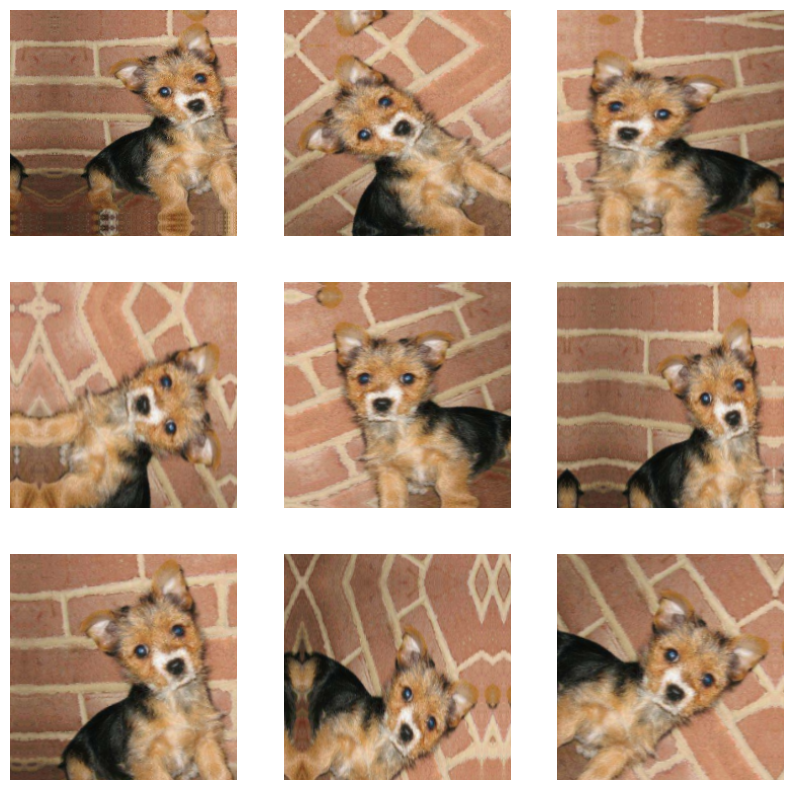

In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
"""
https://stackoverflow.com/questions/68449103/tf-keras-preprocessing-image-dataset-from-directory-value-error-no-images-found
train_folder = "data/dog-breed-identification/train"
validation_folder = "data/dog-breed-identification/test"
train_dataset = image_dataset_from_directory(train_folder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(validation_folder,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)
"""
train_dataset = train_data.prefetch(buffer_size=AUTOTUNE)

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = augmenter(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

## The Model

In [82]:
# UNQ_C2
# GRADED FUNCTION
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input
def CreateModel(image_shape, output_shape, data_augmentation, learning_rate:float = 0.01):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2L
    base_model = EfficientNetV2L(input_shape=image_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights="imagenet", include_preprocessing=False) # <== Default True expects input to have value [0, 255] but the images have be rescaled with convert_image_dtype in ProcessImage()
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    if data_augmentation:
        # create the input layer (Same as the imageNetv2 input size)
        inputs = tf.keras.Input(shape=image_shape)
        
        # apply data augmentation to the inputs
        x = data_augmentation(inputs)
        #x = preprocess_input(x)
        # set training to False to avoid keeping track of statistics in the batch norm layer
        x = base_model(x, training=False) 
    else:
        x = base_model.output

    # add the new Multi-class classification layers
    # use global avg pooling to summarize the info in each channel
    x = GlobalAveragePooling2D(name="AveragePooling")(x)
    x = BatchNormalization()(x)

    # include dropout with probability of 0.2 to avoid overfitting
    x = Dropout(0.2, name="FinalDropout")(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = Dense(output_shape, kernel_regularizer=l2(0.1), name="output_layer", activation="softmax")(x) # Linear activation. Decrease kernel_regularizer to fix high bias; Increase to fix high variance. Densely connected, or fully connected
    
    model = tf.keras.Model(inputs, outputs) if data_augmentation else tf.keras.Model(base_model.input, outputs)
    model.name = "DogBreedsClassification"
    model.compile(optimizer=Adam(learning_rate),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model

In [96]:
def PlotModelPerformance(history):
    acc = [0.] + history.history['accuracy']
    if "val_accuracy" in history.history:
        val_acc = [0.] + history.history['val_accuracy']
    else:
        val_acc = None
    loss = history.history['loss']
    if "val_loss" in history.history:
        val_loss = history.history['val_loss']
    else:
        val_loss = None
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    if val_acc:
        plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    if val_loss:
        plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [84]:
# Load the notebook extension
%load_ext tensorboard
NUM_EPOCHS = 10 #@param {type="slider", min:10, max:100, step=10}
def CreateTensorBoardCallback():
    # Create a log directory for storing TensorBoard logs
    logdir = Path(f"logs/dogbreed/{datetime.now().strftime("%Y-%m-%d-%H%M%S")}")
    return TensorBoard(logdir)

def CreateCircuitBreakerCallback(monitor:str="accuracy", patience:int = 3):
    """
    Early-stopping callback which could help prevent overfitting by stopping the training once certain evaluation metrics stop improving / start to plateau.
    """
    return EarlyStopping(monitor=monitor, patience=patience)

base_learning_rate = 0.001
data_augmentation = data_augmenter()
tensorboard = CreateTensorBoardCallback()
circuit_breaker = CreateCircuitBreakerCallback("val_accuracy") # This is not orthogonal as it will affect both the bias (training vs bayes optimal error) and variance (Cross-validation vs training error).

# Original base model
#model = CreateModel(IMG_SHAPE, len(unique_breeds), None, base_learning_rate)
# With data augmentation
model = CreateModel(IMG_SHAPE, len(unique_breeds), data_augmentation, base_learning_rate)
print(f"Number of layers in base_model: {len(model.layers)}")
model.summary()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Number of layers in base_model: 7


Model: "DogBreedsClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AveragePooling                  │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FinalDropout (Dropout)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,905,688 (449.77 MB)

 Trainable params: 156,280 (610.47 KB)

 Non-trainable params: 117,749,408 (449.18 MB)

### Train the model
#### Tensorflow Callbacks
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [85]:
# What does a single batch look like?
image_batch, label_batch = next(iter(train_data))
image_batch.shape, label_batch.shape

# Get a single image with a batch size of 1
single_image_input = tf.expand_dims(image_batch[0], axis=0)
print(f"image: min: {tf.reduce_min(single_image_input)}, max: {tf.reduce_max(single_image_input)}")
# Pass the image through our model
single_image_output_sequential = model(single_image_input)

# Check the output
print(f"output: min: {tf.reduce_min(single_image_output_sequential)}, max: {tf.reduce_max(single_image_output_sequential)}")
print(f"sum: {numpy.sum(single_image_output_sequential)}")
single_image_output_sequential

image: min: 0.0, max: 1.0
output: min: 0.004396413452923298, max: 0.014355395920574665
sum: 1.0


<tf.Tensor: shape=(1, 120), dtype=float32, numpy=
array([[0.00673011, 0.00911291, 0.00932982, 0.00940623, 0.01190686,
        0.00965046, 0.01140279, 0.00782113, 0.00862138, 0.00864468,
        0.00525554, 0.0081    , 0.00927506, 0.00766899, 0.00981623,
        0.0076583 , 0.00883645, 0.00629896, 0.00757379, 0.01423295,
        0.00471531, 0.01055723, 0.00968896, 0.00558559, 0.00913873,
        0.01035597, 0.00898698, 0.00579464, 0.00899085, 0.00629375,
        0.00751215, 0.00731234, 0.00693347, 0.008956  , 0.01198257,
        0.0105032 , 0.00847694, 0.00937324, 0.00442938, 0.0101033 ,
        0.01269921, 0.00887809, 0.00809636, 0.00879907, 0.00608627,
        0.00832357, 0.00722182, 0.00765575, 0.00527507, 0.00861062,
        0.00579559, 0.0118902 , 0.00485431, 0.00987568, 0.00838507,
        0.00834063, 0.00439641, 0.00551389, 0.00483942, 0.01051073,
        0.00697797, 0.00631866, 0.0143554 , 0.00564133, 0.0115775 ,
        0.00740318, 0.00557544, 0.00517526, 0.00970146, 0.00820788

Epoch 1/10
255/256 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5088 - loss: 10.6385

2025-09-29 19:46:18.626542: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 645.27MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5094 - loss: 10.6184

2025-09-29 19:46:57.189599: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 715.95MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


256/256 ━━━━━━━━━━━━━━━━━━━━ 163s 637ms/step - accuracy: 0.6537 - loss: 5.4945 - val_accuracy: 0.8704 - val_loss: 3.1463
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 153s 599ms/step - accuracy: 0.7234 - loss: 2.1712 - val_accuracy: 0.8528 - val_loss: 1.7525
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 154s 603ms/step - accuracy: 0.7144 - loss: 2.1866 - val_accuracy: 0.8724 - val_loss: 1.5688
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 149s 582ms/step - accuracy: 0.7159 - loss: 2.1513 - val_accuracy: 0.8626 - val_loss: 1.5035
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 155s 605ms/step - accuracy: 0.7176 - loss: 2.1514 - val_accuracy: 0.8621 - val_loss: 1.5427
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 154s 600ms/step - accuracy: 0.7051 - loss: 2.1337 - val_accuracy: 0.8631 - val_loss: 1.4561


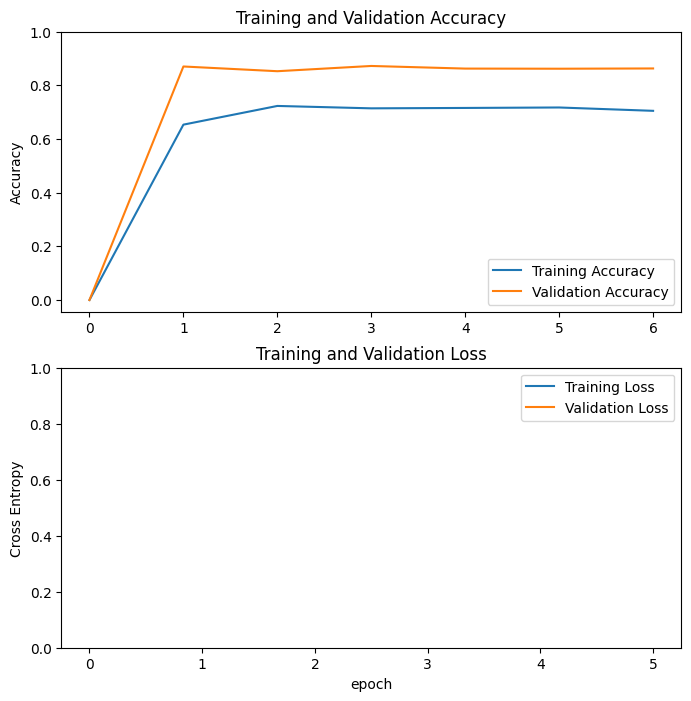

In [87]:
# pipenv run tensorboard --logdir ZTM/logs/dogbreed
history = model.fit(x=train_data, epochs=NUM_EPOCHS, validation_data=validation_data, validation_freq=1, callbacks=[tensorboard, circuit_breaker])
PlotModelPerformance(history)

In [88]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(validation_data, verbose=1) # verbose shows us how long there is to go
predictions

64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 571ms/step


array([[0.00088755, 0.00167903, 0.00103336, ..., 0.00306407, 0.00055842,
        0.00037341],
       [0.00041677, 0.00014979, 0.00023712, ..., 0.00019161, 0.00012817,
        0.00020177],
       [0.00072132, 0.00089333, 0.00225419, ..., 0.00099121, 0.00045266,
        0.00124651],
       ...,
       [0.00030651, 0.00014202, 0.00034548, ..., 0.00052911, 0.00019019,
        0.00015461],
       [0.01131358, 0.00112318, 0.00068147, ..., 0.00065599, 0.0007296 ,
        0.04299557],
       [0.00076355, 0.00215349, 0.00300573, ..., 0.02203668, 0.0006749 ,
        0.00106391]], shape=(2045, 120), dtype=float32)

In [89]:
def GetImageLabel(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label
    """
    assert len(unique_breeds) == len(prediction_probabilities)
    return unique_breeds[numpy.argmax(prediction_probabilities)]

# Extract elements of data from data batch
def ExtractBatch(data):
    """
    Takes a batched dataset of (image, label) tensors and return separate arrays of images and labels
    """
    images = []
    labels = []
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[numpy.argmax(label)])
    return images, labels

def ValidatePrediction(prediction_probabilities, truth, image):
    label = GetImageLabel(prediction_probabilities)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    colour = "green" if label == truth else "red"
    plt.title(f"{label} {numpy.max(prediction_probabilities) * 100 :2.0f}% - {truth}", color = colour)

def ValidateTop10Predictions(prediction_probabilities, truth):
    # Get the top-10 prediction probabilities in descending order.
    top10_indices = prediction_probabilities.argsort()[-10:][::-1]
    top10_probabilities = prediction_probabilities[top10_indices]
    top10_labels = unique_breeds[top10_indices]
    #plt.imshow(image)
    #plt.xticks([])
    #plt.yticks([])
    #colour = "green" if label == truth else "red"
    #plt.title(f"{label} {numpy.max(prediction_probabilities) * 100 :2.0f}% - {truth}", colour = colour)
    plots = plt.bar(numpy.arange(len(top10_labels)), top10_probabilities, color="grey")
    plt.xticks(numpy.arange(len(top10_labels)), labels=top10_labels, rotation="vertical")
    # Change colors of the true labels
    if numpy.isin(truth, top10_labels):
        plots[numpy.argmax(truth == top10_labels)].set_color("green")
    


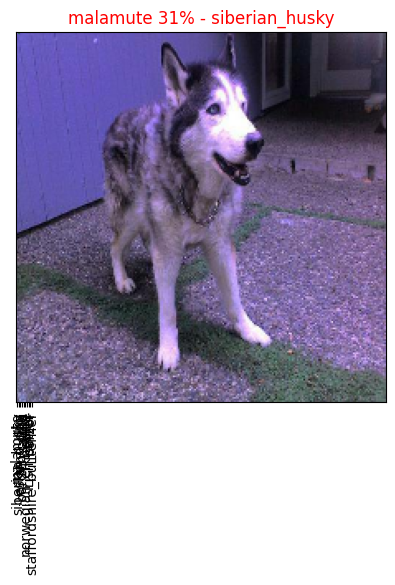

In [90]:
images, labels = ExtractBatch(validation_data)
index = 100
ValidatePrediction(predictions[index], labels[index], images[index])
ValidateTop10Predictions(predictions[index], labels[index])

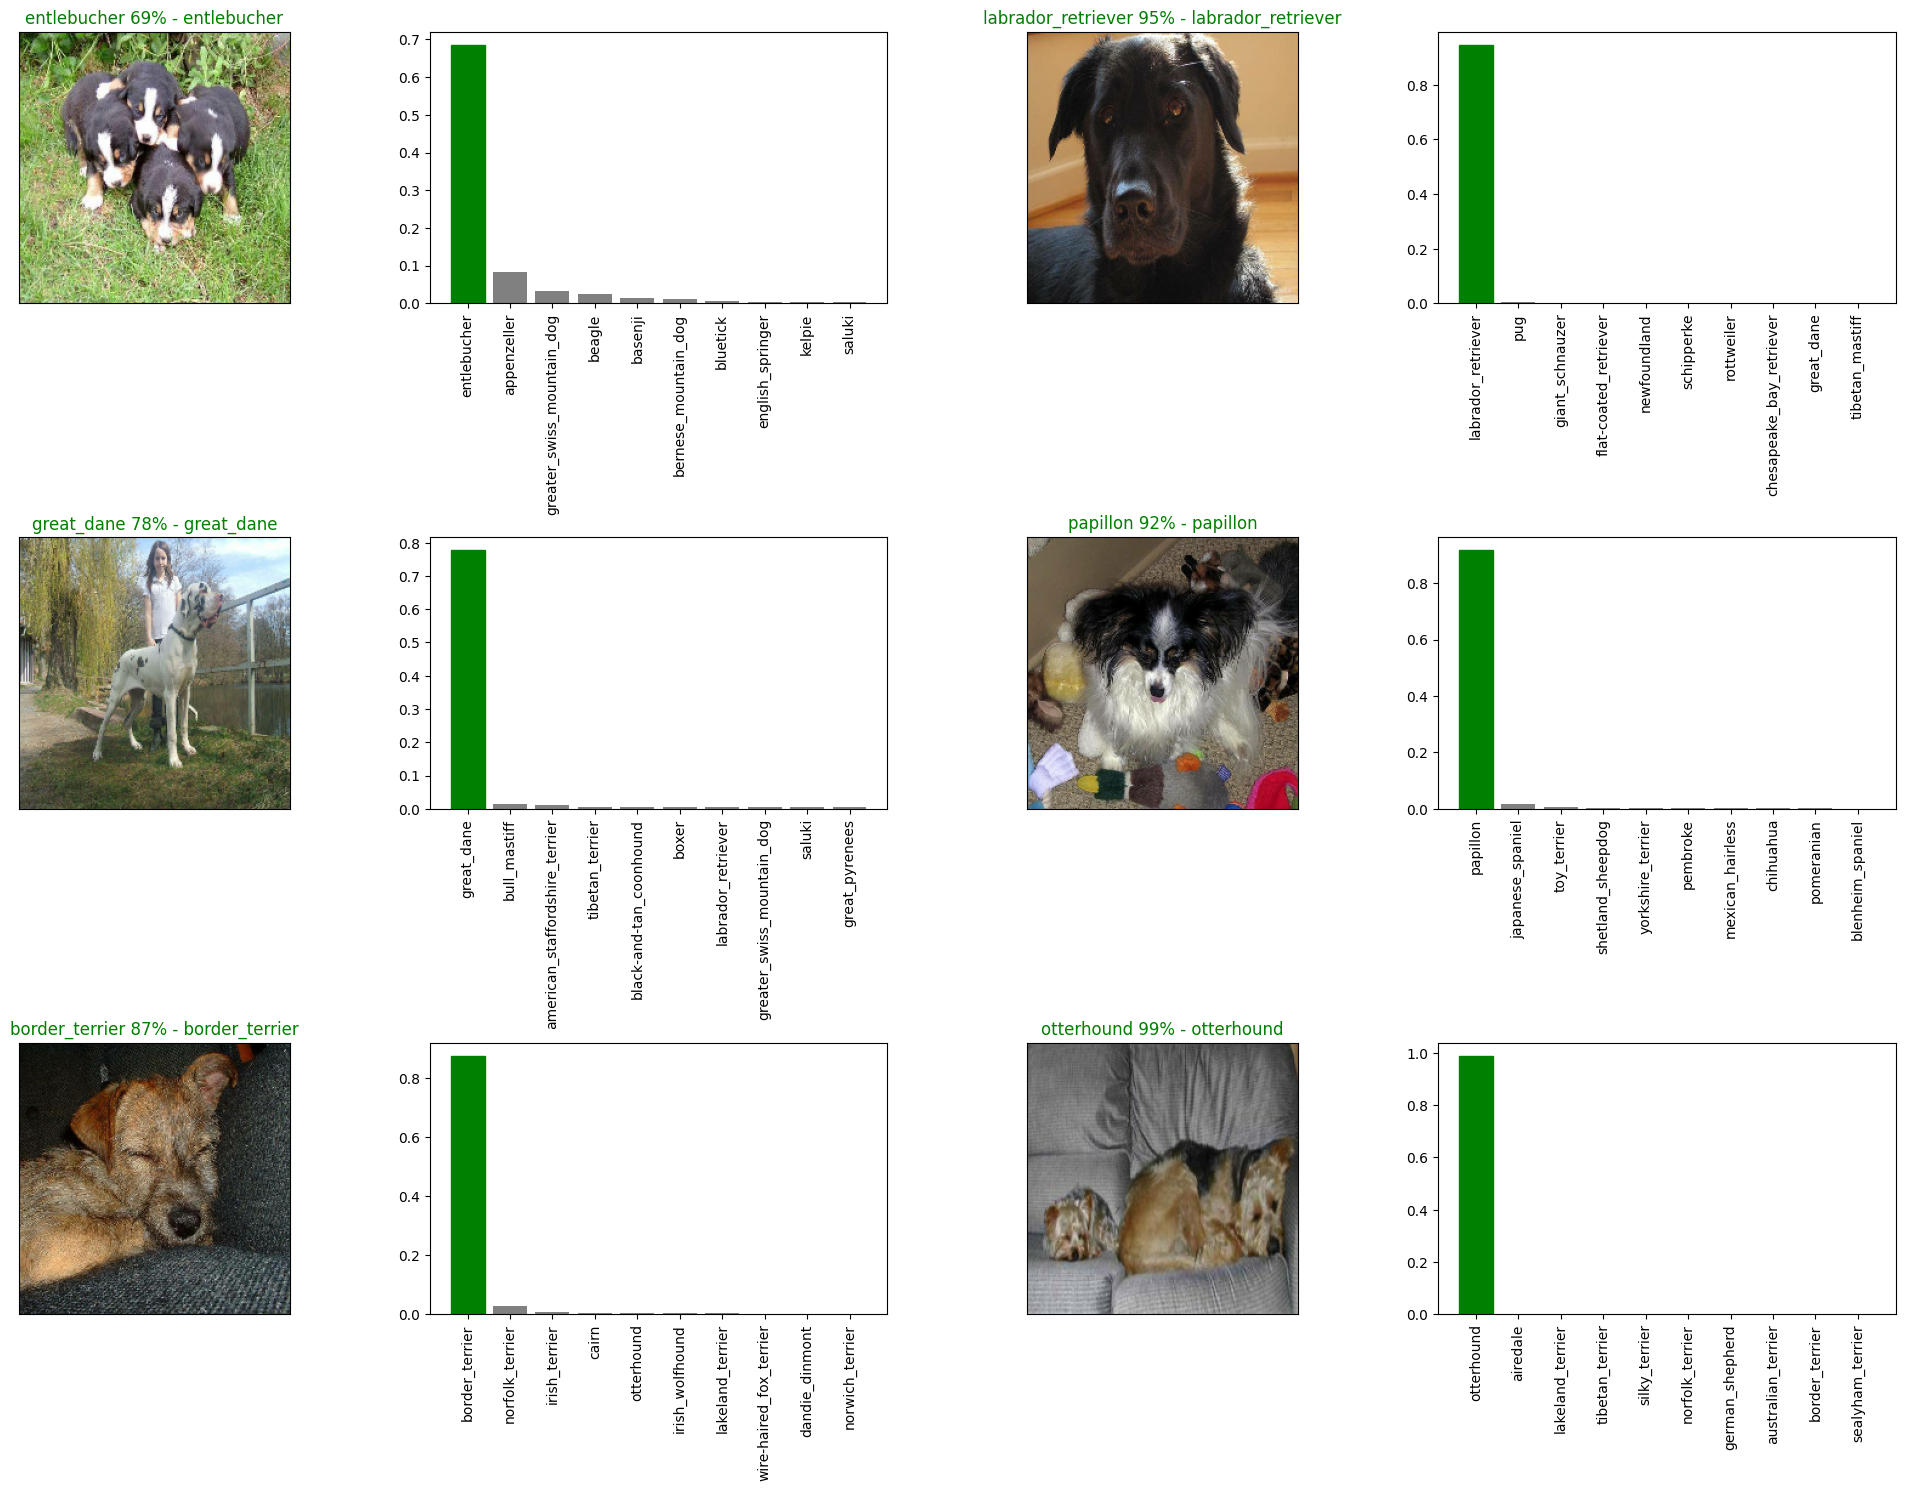

In [91]:
# Let's check a few predictions and their different values
offset = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  ValidatePrediction(predictions[i+offset],
            labels[i+offset],
            images[i+offset],
            )
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  ValidateTop10Predictions(predictions[i+offset],
                labels[i+offset])
plt.tight_layout(h_pad=1.0)
plt.show()

7 layers
model 0: input_layer_29
model 1: data_augmentation
model 2: efficientnetv2-l
model 3: AveragePooling
model 4: batch_normalization_8
model 5: FinalDropout
model 6: output_layer
base_model.name: efficientnetv2-l
Number of layers in the base model:  1027
Epoch 1/100


E0000 00:00:1759147478.352788  981052 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/DogBreedsClassification_1/efficientnetv2-l_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 ━━━━━━━━━━━━━━━━━━━━ 196s 648ms/step - accuracy: 0.7623 - loss: 1.4753 - val_accuracy: 0.8885 - val_loss: 0.9243
Epoch 2/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 154s 600ms/step - accuracy: 0.7766 - loss: 1.3479 - val_accuracy: 0.8851 - val_loss: 0.8725
Epoch 3/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 168s 656ms/step - accuracy: 0.7780 - loss: 1.2987 - val_accuracy: 0.8861 - val_loss: 0.8595
Epoch 4/100
256/256 ━━━━━━━━━━━━━━━━━━━━ 169s 661ms/step - accuracy: 0.7849 - loss: 1.2541 - val_accuracy: 0.8861 - val_loss: 0.8495


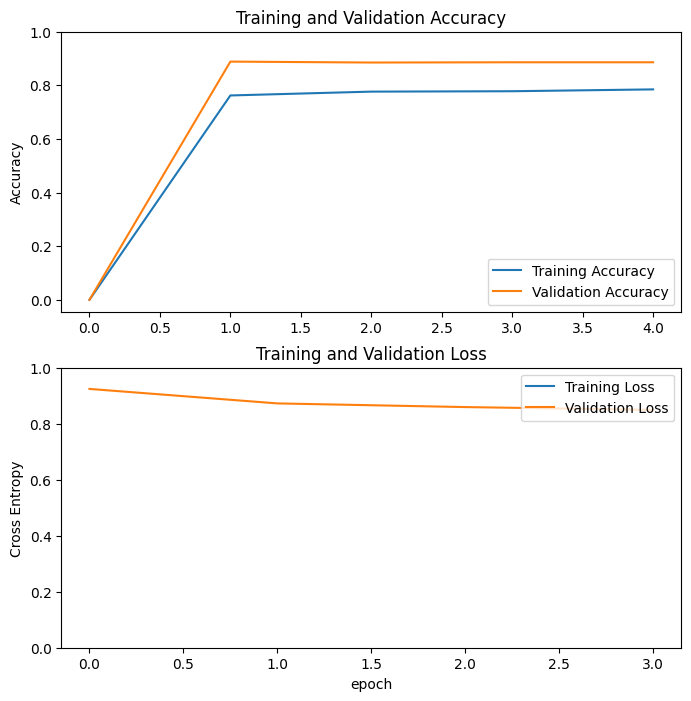

In [93]:
# Fine-tune the model
nb_layers = len(model.layers)
print(f"{nb_layers} layers")

for i in range(nb_layers):
    print(f"model {i}: {model.layers[i].name}")

base_model = model.layers[2] # efficientnetv2-l
print(f"base_model.name: {base_model.name}")
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
# Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.
fine_tune_at = len(base_model.layers) - 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(0.1 * base_learning_rate),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(x=train_data, epochs=100, validation_data=validation_data, validation_freq=1, callbacks=[tensorboard, circuit_breaker])
PlotModelPerformance(history)

In [94]:
# Save model
def SaveModel(model, prefix:str = None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
  model_path = f"models/{prefix}-{timestamp}.keras"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

def LoadModel(path: str):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {path}")
  model = tf.keras.models.load_model(path, custom_objects={"KerasLayer": hub.KerasLayer}) # custom_objects:	Optional dictionary mapping names (strings) to custom classes or functions to be considered during deserialization.
  return model  

In [ ]:
#model = LoadModel(...)
model.evaluate(validation_data)

NameError: name 'model' is not defined

# Train on complete dataset

Create training data batches...
Epoch 1/100
319/320 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.7878 - loss: 1.2141

2025-09-29 20:21:42.028162: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 627.59MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


320/320 ━━━━━━━━━━━━━━━━━━━━ 164s 512ms/step - accuracy: 0.7813 - loss: 1.2393
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 153s 478ms/step - accuracy: 0.7928 - loss: 1.1917
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 173s 542ms/step - accuracy: 0.7925 - loss: 1.1718
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 176s 550ms/step - accuracy: 0.8013 - loss: 1.1374
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 151s 472ms/step - accuracy: 0.8070 - loss: 1.1131
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 146s 456ms/step - accuracy: 0.8134 - loss: 1.0802
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 145s 453ms/step - accuracy: 0.8182 - loss: 1.0554
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 449ms/step - accuracy: 0.8218 - loss: 1.0470
Epoch 9/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 451ms/step - accuracy: 0.8341 - loss: 1.0020
Epoch 10/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 449ms/step - accuracy: 0.8382 - loss: 0.9929
Epoch 11/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 144s 449ms/step - accuracy: 0.8422 - loss: 0.9637
Epoch 12/

UnboundLocalError: cannot access local variable 'val_acc' where it is not associated with a value

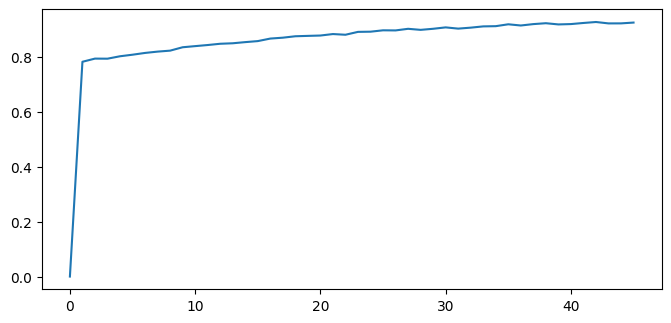

In [ ]:
# Train on complete dataset
len(X), len(Y)
train_data = create_data_batches(X, Y, BATCH_SIZE)
train_data
tensorboard = CreateTensorBoardCallback()
circuit_breaker = CreateCircuitBreakerCallback("accuracy", 5) # Since we don't have the validation dataset
history = model.fit(x=train_data,epochs=100, callbacks=[tensorboard, circuit_breaker])
PlotModelPerformance(history)

In [98]:
model.summary()
#SaveModel(model, "MobileNetV3Large-224-dogbreed")
SaveModel(model, "EfficientNetV2L-224-dogbreed")

Model: "DogBreedsClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 7, 7, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AveragePooling                  │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FinalDropout (Dropout)          │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,728,010 (533.02 MB)

 Trainable params: 10,911,160 (41.62 MB)

 Non-trainable params: 106,994,528 (408.15 MB)

 Optimizer params: 21,822,322 (83.25 MB)

Saving model to: models/EfficientNetV2L-224-dogbreed-20250929-221429.keras...


'models/EfficientNetV2L-224-dogbreed-20250929-221429.keras'

## Make predictions on test dataset

In [99]:
# Make predictions on test dataset
test_path = "data/dog-breed-identification/test"
test_filenames = [f"{test_path}/{f}" for f in os.listdir(test_path)]
len(test_filenames)
test_filenames[:10]
test_data = create_data_batches(test_filenames, None, BATCH_SIZE, isTest=True)
test_data.element_spec # TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)
predictions = model.predict(test_data, verbose=1) # verbose shows us how long there is to go
numpy.savetxt(f"models/dogbreed_predictions.csv", predictions, delimiter=",")

Create test data batches...
323/324 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step

2025-09-29 22:17:08.738004: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 668.83MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


324/324 ━━━━━━━━━━━━━━━━━━━━ 154s 457ms/step


In [100]:
# Kaggle submission format
# id,affenpinscher,afghan_hound,..,yorkshire_terrier
# 000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
# id is the test/{id}.jpg
kaggle_data = pd.DataFrame(columns=["id"] + list(unique_breeds))
#kaggle_data.head()
# Extract ids from path
kaggle_data.id = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
kaggle_data[list(unique_breeds)] = predictions
kaggle_data.head()
kaggle_data.to_csv(f"models/kaggle_submission.csv", index=False)